# PimaAnalysis_ROC_AUC

## Import package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from scipy.stats import norm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

sns.set(style = 'whitegrid',context = 'notebook')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 175)

## Import data

In [2]:
diabetes = pd.read_csv("diabetes.csv")
diabetes.shape

(768, 9)

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


   => There are 9 attributes and 768 observations in the data set
   + Independent variables: Pregnancies, Glucose, BloodPressure, SkinThicknewss, Insulin, BMI, DiabetesPedigreeFunction, Age
   + Target variable: Outcome, with 0 for no diabetes and 1 for having diabetes

## Data Cleaning/ Data Preparation

### Check missing data

In [4]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Unexpected Outlier

In [6]:
# Blood pressure
print(diabetes[diabetes.BloodPressure==0].shape[0])
diabetes['BloodPressure'] = diabetes['BloodPressure'].replace(to_replace=0, value=diabetes['BloodPressure'].median())
print(diabetes[diabetes.BloodPressure==0].shape[0])

# Plasma glucose levels
print(diabetes[diabetes.Glucose == 0].shape[0])
diabetes['Glucose'] = diabetes['Glucose'].replace(to_replace=0, value=diabetes['Glucose'].median())
print(diabetes[diabetes.Glucose == 0].shape[0])

# BMI 
diabetes[diabetes.BMI == 0].shape[0]
diabetes['BMI'] = diabetes['BMI'].replace(to_replace=0, value=diabetes['BMI'].median())
diabetes[diabetes.BMI == 0].shape[0]

# Insulin
print(diabetes[diabetes.Insulin == 0].shape[0])
# diabetes['Insulin'] = diabetes['Insulin'].replace(to_replace=0, value=diabetes['Insulin'].median())
print(diabetes[diabetes.Insulin == 0].shape[0])

# Skin Fold Thickness
print(diabetes[diabetes.SkinThickness == 0].shape[0])
# diabetes['SkinThickness'] = diabetes['SkinThickness'].replace(to_replace=0, value=diabetes['SkinThickness'].median())
print(diabetes[diabetes.SkinThickness == 0].shape[0])

35
0
5
0
374
374
227
227


In [7]:
diabetes_mod = diabetes.copy()

### Split data in to feature space and label

In [8]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

org_X = diabetes_mod[feature_names]
y = diabetes_mod.Outcome

### Data Normalization

In [9]:
# Apply a scaler
from sklearn.preprocessing import MinMaxScaler as Scaler

scaler = Scaler()
scaler.fit(org_X)
X = scaler.transform(org_X)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Split data into train set and test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=diabetes_mod.Outcome, random_state=0)

# Logistic Regression

#### Train model

In [11]:
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Coefficients

In [12]:
coefficient_list = list(logit_model.coef_[0])
feature_coefficient = [(feature, coefficient) for feature, coefficient in zip(feature_names, coefficient_list)]
feature_coefficient

[('Pregnancies', 1.299663729994212),
 ('Glucose', 3.599135846826891),
 ('BloodPressure', -0.324167572450868),
 ('SkinThickness', -0.275670636062207),
 ('Insulin', 0.3162198421697331),
 ('BMI', 2.4913687761804173),
 ('DiabetesPedigreeFunction', 1.1927429704616024),
 ('Age', 1.0159498591591678)]

In [13]:
#get feature importances from the model
headers = ["name", "score"]
coefficient_list = np.abs(list(logit_model.coef_[0]))
values = sorted(zip(feature_names, coefficient_list), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)
feature_importances

,name,score
0,Glucose,3.599136
1,BMI,2.491369
2,Pregnancies,1.299664
3,DiabetesPedigreeFunction,1.192743
4,Age,1.015950
5,BloodPressure,0.324168
6,Insulin,0.316220
7,SkinThickness,0.275671


=> Important features from the model: Glucose, BMI, Age, Pregnancies

#### p-value

In [14]:
# Calculat p-value of Logistic Regression: http://desktop-f4vfjmc:8888/notebooks/0_MyProjects/Finance/02-CreditRiskAnalysis.ipynb


#### Predicting label

In [15]:
y_train_pred = logit_model.predict(X_train)
y_test_pred = logit_model.predict(X_test)

#### Model Evaluation

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

Accuracy score

In [17]:
print('Train: %.3f , Test: %.3f' % (accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred)))

Train: 0.780 , Test: 0.760


Confusion Matrix

In [18]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=logit_model.classes_,columns=logit_model.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True         0   1
Predicted         
0          111  14
1           32  35


In [19]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[111  14]
 [ 32  35]]


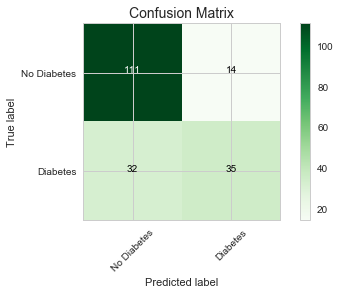

In [20]:
cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

Compute precision, recall, F-measure and support

In [21]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       125
           1       0.71      0.52      0.60        67

   micro avg       0.76      0.76      0.76       192
   macro avg       0.75      0.71      0.72       192
weighted avg       0.75      0.76      0.75       192



Computing false and true positive rates

In [22]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
aaprint(thresholds)

[1.89024174 0.89024174 0.86817842 0.81819239 0.73938069 0.71910674
 0.69405536 0.69146884 0.67243489 0.66120965 0.65552937 0.65021561
 0.65003832 0.64625406 0.63917522 0.61290515 0.60995736 0.6079789
 0.59496614 0.59054201 0.59043715 0.5808392  0.5582206  0.55049643
 0.54959973 0.50304321 0.49125213 0.44376033 0.42603633 0.42392652
 0.42240983 0.41843063 0.41201728 0.41072484 0.40282394 0.39149933
 0.38247484 0.37805032 0.37382109 0.3735001  0.35890832 0.35764429
 0.35623751 0.34628519 0.33120894 0.32311987 0.30711377 0.30438707
 0.30309778 0.30254771 0.30190069 0.30176408 0.29577042 0.28985742
 0.28953755 0.26608247 0.26334613 0.25738009 0.25471688 0.24448714
 0.24411753 0.21634618 0.21344815 0.20962215 0.20837505 0.17500159
 0.17376471 0.15307995 0.15172326 0.04539086]


Calculate AUC

In [23]:
roc_auc = roc_auc_score(y_test,y_test_pred)
print('AUC: %.3f' % roc_auc)


AUC: 0.705


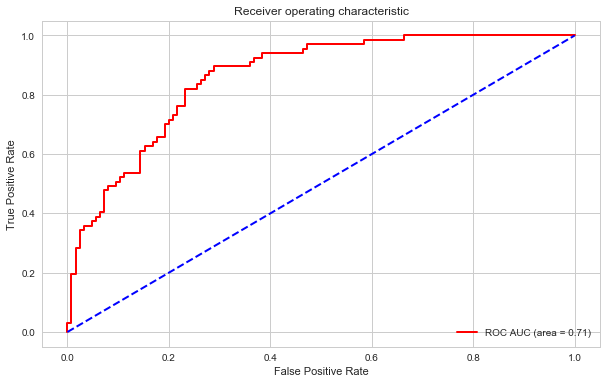

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc)
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Recall vs. Precision Thresholding
Look at recall vs. precision to see the trade-off between the two

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.75')

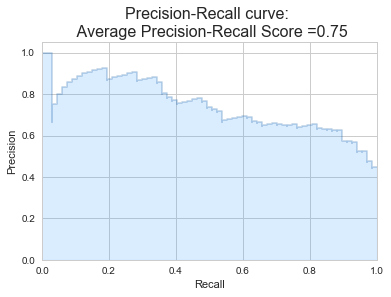

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = logit_model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

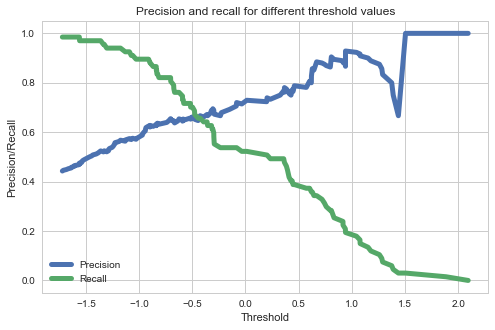

In [26]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Threshold for logistic regression

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

Confusion matrix, without normalization
[[42 83]
 [ 0 67]]
              precision    recall  f1-score   support

           0       1.00      0.34      0.50       125
           1       0.45      1.00      0.62        67

   micro avg       0.57      0.57      0.57       192
   macro avg       0.72      0.67      0.56       192
weighted avg       0.81      0.57      0.54       192

[2 1 0]
[0.    0.664 1.   ]
[0. 1. 1.]


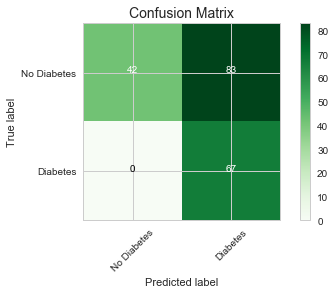

In [28]:
THRESHOLD = 0.15172326
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[65 60]
 [ 2 65]]
              precision    recall  f1-score   support

           0       0.97      0.52      0.68       125
           1       0.52      0.97      0.68        67

   micro avg       0.68      0.68      0.68       192
   macro avg       0.75      0.75      0.68       192
weighted avg       0.81      0.68      0.68       192

[2 1 0]
[0.   0.48 1.  ]
[0.         0.97014925 1.        ]


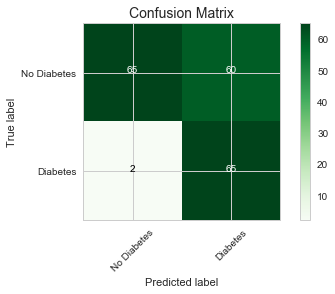

In [29]:
THRESHOLD = 0.2040451
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[90 35]
 [ 9 58]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       125
           1       0.62      0.87      0.72        67

   micro avg       0.77      0.77      0.77       192
   macro avg       0.77      0.79      0.76       192
weighted avg       0.81      0.77      0.78       192

[2 1 0]
[0.   0.28 1.  ]
[0.         0.86567164 1.        ]


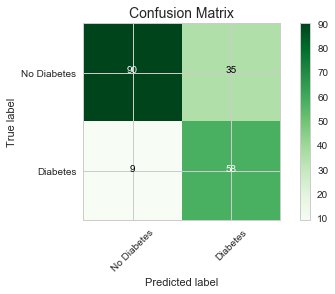

In [30]:
THRESHOLD = 0.301764
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[103  22]
 [ 23  44]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       125
           1       0.67      0.66      0.66        67

   micro avg       0.77      0.77      0.77       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.76      0.77      0.77       192

[2 1 0]
[0.    0.176 1.   ]
[0.         0.65671642 1.        ]


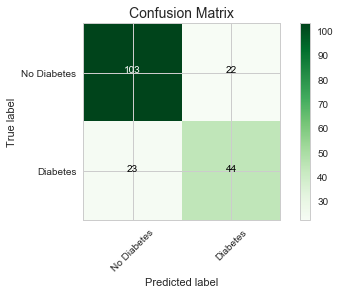

In [31]:
THRESHOLD = 0.402823
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[111  14]
 [ 32  35]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       125
           1       0.71      0.52      0.60        67

   micro avg       0.76      0.76      0.76       192
   macro avg       0.75      0.71      0.72       192
weighted avg       0.75      0.76      0.75       192

[2 1 0]
[0.    0.112 1.   ]
[0.         0.52238806 1.        ]


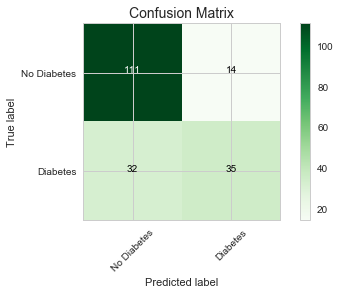

In [32]:
THRESHOLD = 0.503043
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[116   9]
 [ 38  29]]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       125
           1       0.76      0.43      0.55        67

   micro avg       0.76      0.76      0.76       192
   macro avg       0.76      0.68      0.69       192
weighted avg       0.76      0.76      0.73       192

[2 1 0]
[0.    0.072 1.   ]
[0.         0.43283582 1.        ]


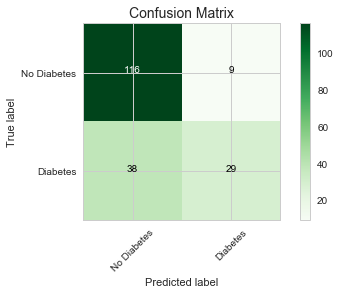

In [34]:
THRESHOLD = 0.601017
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[123   2]
 [ 50  17]]
              precision    recall  f1-score   support

           0       0.71      0.98      0.83       125
           1       0.89      0.25      0.40        67

   micro avg       0.73      0.73      0.73       192
   macro avg       0.80      0.62      0.61       192
weighted avg       0.78      0.73      0.68       192

[2 1 0]
[0.    0.016 1.   ]
[0.         0.25373134 1.        ]


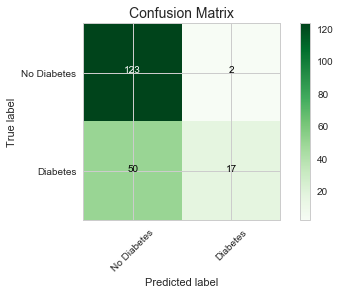

In [35]:
THRESHOLD = 0.714318
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[124   1]
 [ 63   4]]
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       125
           1       0.80      0.06      0.11        67

   micro avg       0.67      0.67      0.67       192
   macro avg       0.73      0.53      0.45       192
weighted avg       0.71      0.67      0.56       192

[2 1 0]
[0.    0.008 1.   ]
[0.         0.05970149 1.        ]


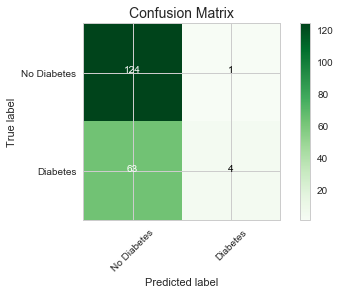

In [36]:
THRESHOLD = 0.80037
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

##### threshold = 0.1

Confusion matrix, without normalization
[[ 16 109]
 [  0  67]]
              precision    recall  f1-score   support

           0       1.00      0.13      0.23       125
           1       0.38      1.00      0.55        67

   micro avg       0.43      0.43      0.43       192
   macro avg       0.69      0.56      0.39       192
weighted avg       0.78      0.43      0.34       192



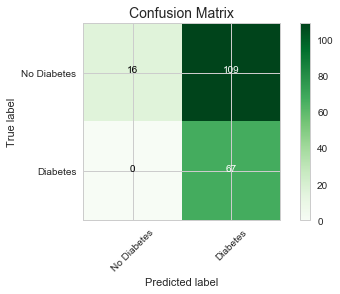

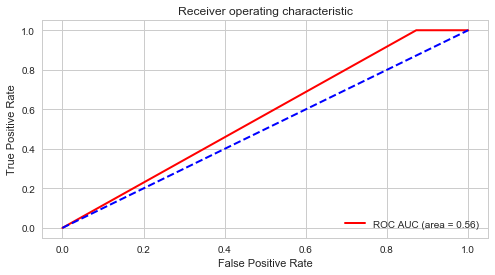

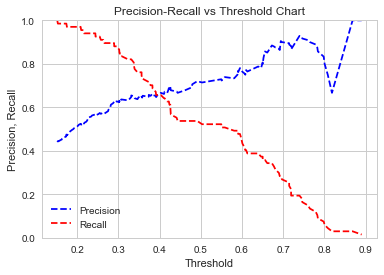

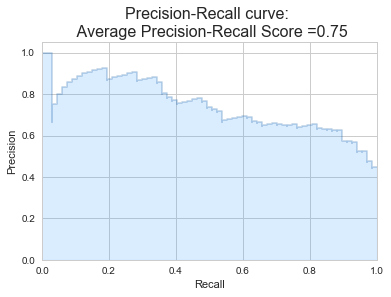

In [37]:
THRESHOLD = 0.1
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (8,4))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[42 83]
 [ 0 67]]
              precision    recall  f1-score   support

           0       1.00      0.34      0.50       125
           1       0.45      1.00      0.62        67

   micro avg       0.57      0.57      0.57       192
   macro avg       0.72      0.67      0.56       192
weighted avg       0.81      0.57      0.54       192



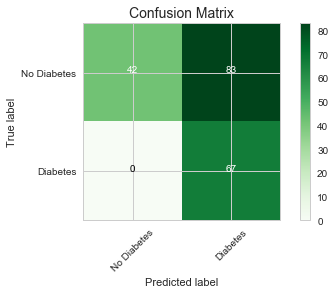

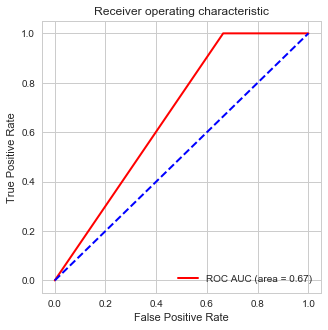

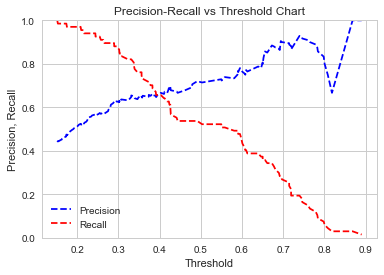

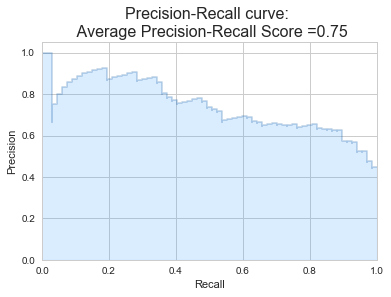

In [38]:
THRESHOLD = 0.15172326
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[65 60]
 [ 2 65]]
              precision    recall  f1-score   support

           0       0.97      0.52      0.68       125
           1       0.52      0.97      0.68        67

   micro avg       0.68      0.68      0.68       192
   macro avg       0.75      0.75      0.68       192
weighted avg       0.81      0.68      0.68       192



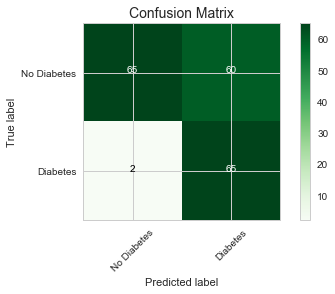

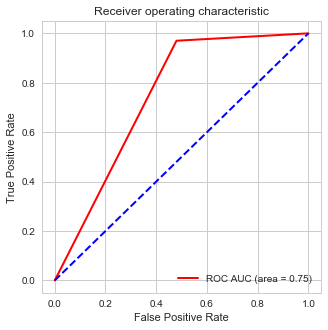

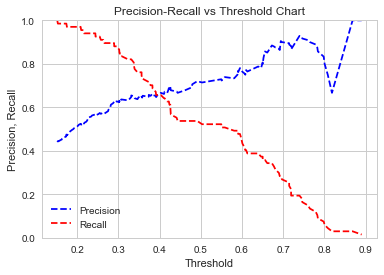

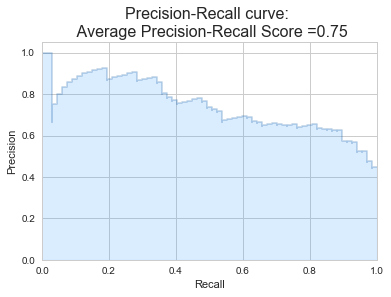

In [39]:
THRESHOLD = 0.2040451
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[90 35]
 [ 9 58]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       125
           1       0.62      0.87      0.72        67

   micro avg       0.77      0.77      0.77       192
   macro avg       0.77      0.79      0.76       192
weighted avg       0.81      0.77      0.78       192

[2 1 0]
[0.   0.28 1.  ]
[0.         0.86567164 1.        ]


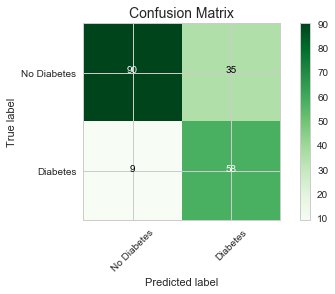

In [40]:
THRESHOLD = 0.301764
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

Confusion matrix, without normalization
[[90 35]
 [ 9 58]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       125
           1       0.62      0.87      0.72        67

   micro avg       0.77      0.77      0.77       192
   macro avg       0.77      0.79      0.76       192
weighted avg       0.81      0.77      0.78       192

[2 1 0]
[0.   0.28 1.  ]
[0.         0.86567164 1.        ]


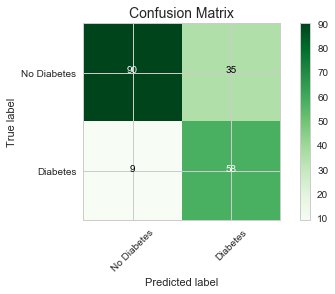

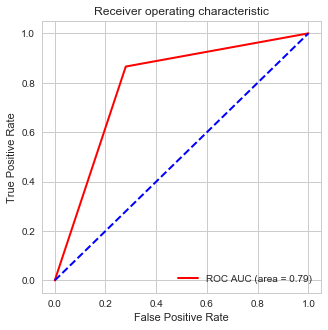

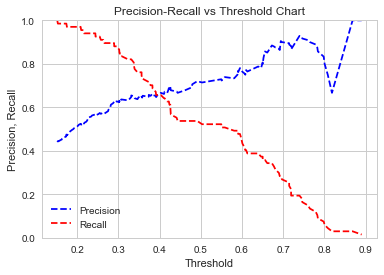

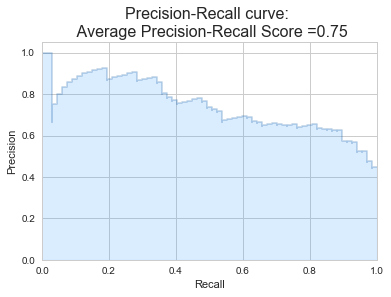

In [41]:
THRESHOLD = 0.301764
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(thresholds)
print(fpr)
print(tpr)

import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[103  22]
 [ 23  44]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       125
           1       0.67      0.66      0.66        67

   micro avg       0.77      0.77      0.77       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.76      0.77      0.77       192



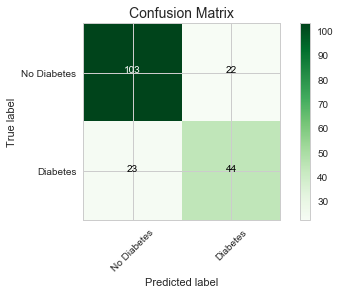

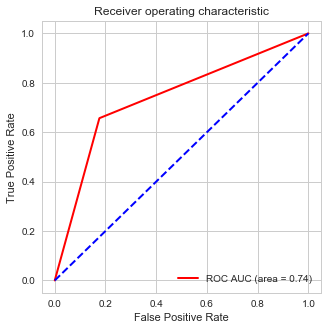

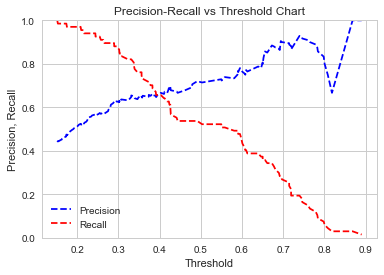

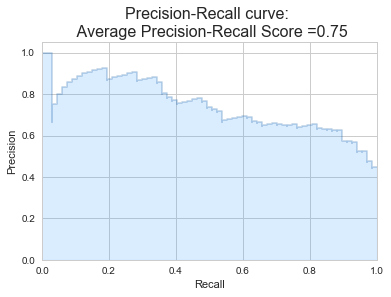

In [42]:
THRESHOLD = 0.402823
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[111  14]
 [ 32  35]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       125
           1       0.71      0.52      0.60        67

   micro avg       0.76      0.76      0.76       192
   macro avg       0.75      0.71      0.72       192
weighted avg       0.75      0.76      0.75       192



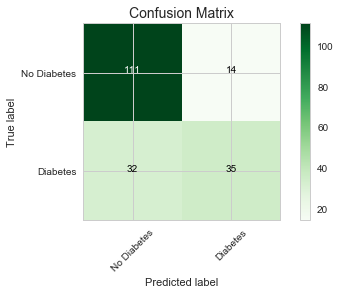

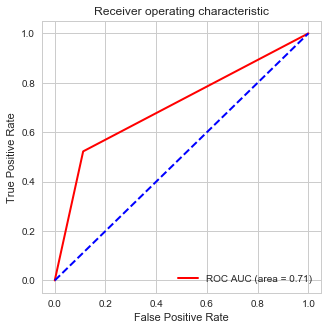

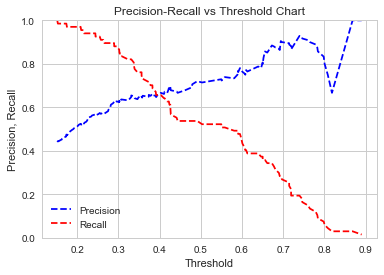

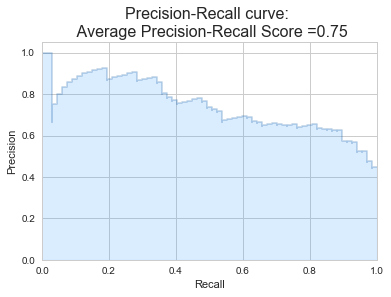

In [43]:
THRESHOLD = 0.503043
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[123   2]
 [ 50  17]]
              precision    recall  f1-score   support

           0       0.71      0.98      0.83       125
           1       0.89      0.25      0.40        67

   micro avg       0.73      0.73      0.73       192
   macro avg       0.80      0.62      0.61       192
weighted avg       0.78      0.73      0.68       192



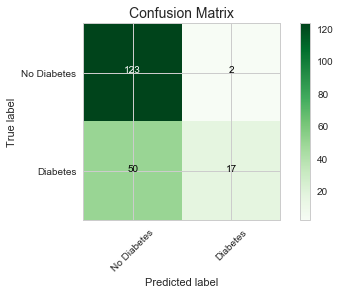

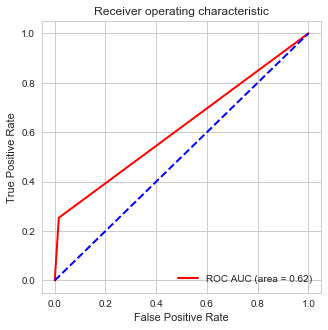

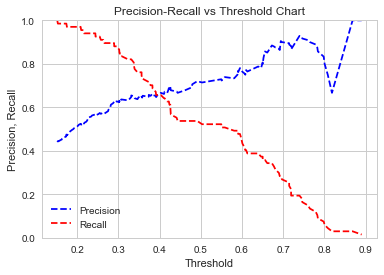

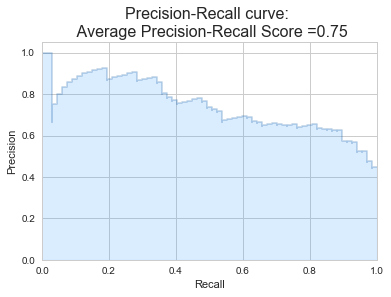

In [45]:
THRESHOLD = 0.714318
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

Confusion matrix, without normalization
[[124   1]
 [ 63   4]]
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       125
           1       0.80      0.06      0.11        67

   micro avg       0.67      0.67      0.67       192
   macro avg       0.73      0.53      0.45       192
weighted avg       0.71      0.67      0.56       192



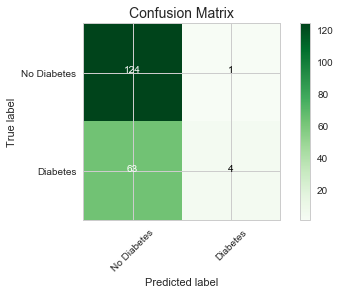

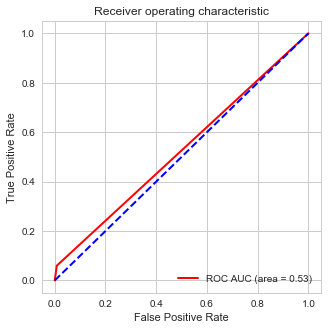

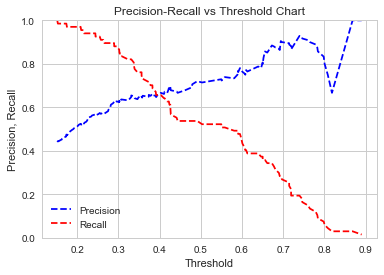

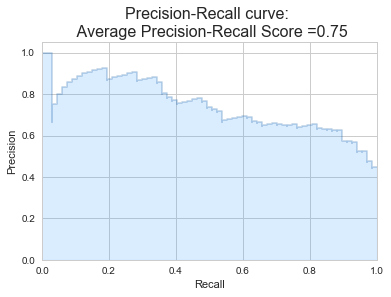

In [46]:
THRESHOLD = 0.800370
y_test_pred = np.where(logit_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

cm_df  = confusion_matrix(y_test, y_test_pred)
labels = ['No Diabetes', 'Diabetes']
plot_confusion_matrix(cm_df , labels, title="Confusion Matrix", cmap=plt.cm.Greens)

pd.DataFrame(data=[accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred),
                   precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

print(classification_report(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC AUC (area = %0.2f)' % roc_auc_score(y_test, y_test_pred))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.plot()
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

y_score = logit_model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
plt.plot()
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

In [ ]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE',fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])